# IEDB T-Cell Response Data Processing

The benchark dataset is created using the following file from the [IEDB database export site](http://www.iedb.org/database_export_v3.php):
`tcell_full_v3` (last update on 25 January 2022).

### Data selection criteria
- T cells from human hosts
- Linear peptides without modified amino acids
- IFNg as assay group
- Positive and negative responses (remove instances with positive-low, positive-intermediate, and positive-high responses)
- Remove peptides which have both positive and negative T-cell response labels.

### MHC alleles
The 100 most frequent MHC alleles in the IEDB T-cell dataset are obtained.
For every peptide:MHC combination, MHC presentation is predicted using NetMHC*.
Peptide:MHC combinations that are identified as weak binders are added to the T-cell response dataset. Peptides without any predicted weak binder are assigned a "default allele".

### Train/valid/test split
Test data leakage is minimized by performing a clustering on peptides. Peptides are assigned to the same cluster if they share a 9-mer sequence. Peptides from the same cluster are assigned to the same partition of the random split of the data. This approach is similar to the one by [Nielsen et al. (2007)](#2).

### References

<a id="2">[1]</a> 
Nielsen, M., Lundegaard, C. & Lund, O. Prediction of MHC class II binding affinity using SMM-align, a novel stabilization matrix alignment method. BMC Bioinformatics 8, 238 (2007). https://doi.org/10.1186/1471-2105-8-238


<br />

In [1]:
import pandas as pd

In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from mhcnames import normalize_allele_name
import numpy as np
import itertools
from pathlib import Path
import mhcgnomes
from mhcgnomes import Allele, Class2Pair
from mhctools import NetMHCpan4_1_EL, NetMHCIIpan4_EL
from sklearn.cluster import spectral_clustering

## Helpers for data processing

In [17]:
def normalize_MHC_name(allele):
    """
    Apply both mhcgnomes and mhctools normalization:
    - mhcgnomes provides easier access to the species and possible mutations
    - mhctools is necessary for running the NetMHC predictors
    Mutated alleles are set to None.
    Non-human alleles are marked as such to later on remove their corresponding peptides.
    """
    parsed_allele = mhcgnomes.parse(allele, raise_on_error=False, required_result_types=[Allele])
    if parsed_allele is not None:
        species = parsed_allele.gene.species.name
        num_mutations = len(parsed_allele.mutations)
    else:
        parsed_allele = mhcgnomes.parse(allele, raise_on_error=False, required_result_types=[Class2Pair])
        if parsed_allele is not None:
            species = parsed_allele.alpha.gene.species.name
            num_mutations = len(parsed_allele.alpha.mutations) + len(parsed_allele.beta.mutations)
        else:
            species = 'Homo sapiens'
            num_mutations = 0
    
    if parsed_allele is None:
        return None
    elif num_mutations > 0:
        return None
    elif species != 'Homo sapiens':
        return 'non-human allele'
    else:
        return normalize_allele_name(parsed_allele.to_string())

In [18]:
def remove_inconsistencies(df):
    """
    Remove peptide:MHC instances that occur with both positive and negative labels
    """
    # set peptides with positive label
    peptides_allele_pos = set(df.loc[(df['Assay Qualitative Measure'] == 'Positive'), 'Epitope Description'].unique())
    
    # set peptides with negative label
    peptides_allele_neg = set(df.loc[(df['Assay Qualitative Measure'] == 'Negative'), 'Epitope Description'].unique())
    
    # set of peptides with both positive and negative label
    peptides_allele_pos_neg = peptides_allele_pos & peptides_allele_neg
    
    # remove inconsistent instances
    consistent_df = df.loc[~df['Epitope Description'].isin(peptides_allele_pos_neg)]
    
    return consistent_df

In [19]:
def get_values_per_column(full_df, selected_column):
    """
    Compute the pos/neg distribution of values for a selected column
    """
    distribution_pos_full_df = full_df.loc[full_df['Assay Qualitative Measure'] == 'Positive', selected_column].fillna('None').value_counts().to_frame()
    distribution_neg_full_df = full_df.loc[full_df['Assay Qualitative Measure'] == 'Negative', selected_column].fillna('None').value_counts().to_frame()
    distribution_merged_df = pd.concat([distribution_pos_full_df, distribution_neg_full_df], axis=1).fillna(0).astype(int)
    distribution_merged_df.columns = ['Positives', 'Negatives']
    return distribution_merged_df

<br />

## Get T-cell response data

In [13]:
# load T cell response data
df_tcell_original = pd.read_csv("../../data/IEDB_versions/tcell_full_v3_25_01_22.csv", dtype="str", header=[0, 1])
df_tcell_original.columns = [' '.join(col).strip() for col in df_tcell_original.columns.values]

In [22]:
# only consider human hosts
human_host = df_tcell_original['Host Name'].isin(['Homo sapiens (human)', 'Homo sapiens', 'Homo sapiens Caucasian', 'Homo sapiens Black'])
df_tcell_human_host = df_tcell_original.loc[human_host].copy()

# normalize HLA names to be in 4-digit format, otherwise None
df_tcell_human_host['MHC Allele Name'] = df_tcell_human_host['MHC Allele Name'].astype(str).apply(lambda allele: normalize_MHC_name(allele))

# remove instances having non-human MHC alleles
df_tcell_human_host = df_tcell_human_host.loc[df_tcell_human_host['MHC Allele Name'] != 'non-human allele']

# only use linear peptides
df_tcell_linear_peptide = df_tcell_human_host.loc[df_tcell_human_host['Epitope Object Type'] == 'Linear peptide']

# select peptides in certain length ranges
# Class I:   NetMHCpan: 8 - 56   MHCflurry: 8 - 15
# Class II:  NetMHCIIpan4: 9 - ?  BertMHC: 7 - 25
peptide_len = df_tcell_linear_peptide['Epitope Description'].str.len()
mhc_class = df_tcell_linear_peptide['MHC Class']
peptide_len_selection = (peptide_len.between(8, 15) & (mhc_class == 'I')) | (peptide_len.between(9, 25) & (mhc_class == 'II'))
df_tcell_peptide_len = df_tcell_linear_peptide.loc[peptide_len_selection]

# only use IFNg as assay group
df_tcell_IFNg = df_tcell_peptide_len.loc[df_tcell_peptide_len['Assay Assay Group'] == 'IFNg release']

# only keep positive and negative responses, remove instances with positive-low, positive-intermediate, and positive-high responses
df_tcell_pos_neg = df_tcell_IFNg.loc[df_tcell_IFNg['Assay Qualitative Measure'].isin(['Positive', 'Negative'])]

# remove instances with peptides containing modified amino acids (e.g., deamination)
is_modified = df_tcell_pos_neg['Epitope Description'].str.contains(' + ', regex=False)
# remove instances with peptides containing lower case amino acids
is_uppercase = df_tcell_pos_neg['Epitope Description'].str.isupper()
# remove instances with X in the epitope sequence
contains_X = df_tcell_pos_neg['Epitope Description'].str.contains('X', regex=False)
# remove peptides having numbers in their sequence
is_alphabetic = df_tcell_pos_neg['Epitope Description'].str.isalpha()
df_tcell_mod_filtered = df_tcell_pos_neg.loc[~is_modified & is_uppercase & ~contains_X & is_alphabetic]

# Insert default value for missing peptide sources
df_tcell_mod_filtered = df_tcell_mod_filtered.fillna({'Epitope Parent Species': 'unknown'})

# remove peptides that have inconsistent labels
df_tcell_consistent = remove_inconsistencies(df_tcell_mod_filtered)

# only keep one entry for each peptide
df_tcell_unique_pep = df_tcell_consistent.drop_duplicates(subset=['Epitope Description'])

<br />

### Statistics on the dataset filtering

In [7]:
processing_steps = [('human host', df_tcell_human_host),
                    ('linear peptide', df_tcell_linear_peptide),
                    ('peptide length', df_tcell_peptide_len),
                    ('only IFNg', df_tcell_IFNg),
                    ('only pos/neg', df_tcell_pos_neg),
                    ('w/o AA modifications', df_tcell_mod_filtered),
                    ('consistency', df_tcell_consistent),
                    ('unique peptides', df_tcell_unique_pep)]

# just an empty df with a response index
pos_neg_split = pd.DataFrame(index=df_tcell_human_host['Assay Qualitative Measure'].value_counts().index)

i = 1
for description, df in processing_steps:
    pos_neg_split[str(i) + ') ' + description] = df['Assay Qualitative Measure'].value_counts().to_frame()
    i += 1

pos_neg_split.fillna(0).astype(int)

,1) human host,2) linear peptide,3) peptide length,4) only IFNg,5) only pos/neg,6) w/o AA modifications,7) consistency,8) unique peptides
Negative,175790,175326,97491,48424,48424,48411,43108,20904
Positive,97909,95819,81139,37582,37582,37461,29968,14707
Positive-Low,6646,6366,4519,1730,0,0,0,0
Positive-High,1598,1517,1273,424,0,0,0,0
Positive-Intermediate,708,671,450,159,0,0,0,0


<br />

## Perform NetMHC presentation predictions

In [26]:
peptide_list_I = list(df_tcell_consistent.loc[df_tcell_consistent['MHC Class'] == 'I', 'Epitope Description'].unique())
peptide_list_II = list(df_tcell_consistent.loc[df_tcell_consistent['MHC Class'] == 'II', 'Epitope Description'].unique())

In [ ]:
# Get lists of the most frequent MHC alleles in the IEDB T-cell response data
# Do it in two steps, first for the top 50 and then the following 50 most frequent alleles, just for computational reasons
class_I_alleles = set(df_tcell_consistent.loc[df_tcell_consistent['MHC Class'] == 'I', 'MHC Allele Name'].unique())
class_II_alleles = set(df_tcell_consistent.loc[df_tcell_consistent['MHC Class'] == 'II', 'MHC Allele Name'].unique())
top_50_alleles = set(df_tcell_consistent['MHC Allele Name'].value_counts().iloc[:50].index)
top_100_alleles = set(df_tcell_consistent['MHC Allele Name'].value_counts().iloc[:100].index)
top_100_alleles_I = list(top_100_alleles & class_I_alleles)
top_100_alleles_II = list(top_100_alleles & class_II_alleles)
top_50_100_alleles = set(df_tcell_consistent['MHC Allele Name'].value_counts().iloc[50:100].index)
top_50_alleles_I = list(top_50_alleles & class_I_alleles)
top_50_alleles_II = list(top_50_alleles & class_II_alleles)
top_50_100_alleles_I = list(top_50_100_alleles & class_I_alleles)
top_50_100_alleles_II = list(top_50_100_alleles & class_II_alleles)

In [29]:
NetMHCpan4_1_EL_predictions_50 = NetMHCpan4_1_EL(alleles=top_50_alleles_I).predict_peptides_dataframe(peptide_list_I)

In [31]:
NetMHCpan4_1_EL_predictions_50.to_csv('NetMHCpan4_1_EL_predictions_50.csv')

In [32]:
NetMHCpan4_1_EL_predictions_50_100 = NetMHCpan4_1_EL(alleles=top_50_100_alleles_I).predict_peptides_dataframe(peptide_list_I)

In [33]:
NetMHCpan4_1_EL_predictions_50_100.to_csv('NetMHCpan4_1_EL_predictions_50_100.csv')

In [35]:
NetMHCIIpan4_EL_predictions_50 = NetMHCIIpan4_EL(alleles=top_50_alleles_II).predict_peptides_dataframe(peptide_list_II)

In [36]:
NetMHCIIpan4_EL_predictions_50.to_csv('NetMHCIIpan4_EL_predictions_50.csv')

In [37]:
NetMHCIIpan4_EL_predictions_50_100 = NetMHCIIpan4_EL(alleles=top_50_100_alleles_II).predict_peptides_dataframe(peptide_list_II)

In [38]:
NetMHCIIpan4_EL_predictions_50_100.to_csv('NetMHCIIpan4_EL_predictions_50_100.csv')

In [52]:
NetMHC_predictions_merged_50 = pd.concat([NetMHCpan4_1_EL_predictions_50, NetMHCIIpan4_EL_predictions_50])
NetMHC_predictions_merged_100 = pd.concat([NetMHC_predictions_merged_50, NetMHCpan4_1_EL_predictions_50_100, NetMHCIIpan4_EL_predictions_50_100])

<br />

## Add NetMHC presentation predictions to the T-cell response datasest

In [630]:
def fill_in_default_allele(mhc_allele, mhc_class):
    if pd.notna(mhc_allele):
        return mhc_allele
    elif mhc_class == 'I':
        return 'default allele I'
    else:
        return 'default allele II'

In [701]:
def fill_in_mhc_class(mhc_predictor, mhc_class):
    if mhc_predictor == 'netMHCpan':
        return 'I'
    elif mhc_predictor == 'netMHCIIpan':
        return 'II'
    else:
        return mhc_class

In [39]:
NetMHC_I_predictions_merged = pd.concat([NetMHCpan4_1_EL_predictions_50, NetMHCpan4_1_EL_predictions_50_100])
NetMHC_II_predictions_merged = pd.concat([NetMHCIIpan4_EL_predictions_50, NetMHCIIpan4_EL_predictions_50_100])

In [48]:
NetMHC_I_predictions_merged.to_csv('NetMHC_I_predictions_merged.csv')

In [49]:
NetMHC_II_predictions_merged.to_csv('NetMHC_II_predictions_merged.csv')

In [704]:
def add_predicted_alleles(original_df, mhctools_df):
    weak_binders = mhctools_df.loc[mhctools_df['percentile_rank'] <= 2.]
    
    # Add rows for each peptide:MHC combination for evaluation
    prediction_df = weak_binders[['peptide', 'allele', 'prediction_method_name']].copy()
    prediction_df.columns = ['Epitope Description', 'MHC Allele Prediction', 'MHC Predictor Name']
    combined_df = original_df.merge(prediction_df, how='left', on=['Epitope Description'])
    
    # Reassign the correct MHC class since some peptides have both class I and II alleles.
    combined_df['MHC Class'] = combined_df[['MHC Predictor Name', 'MHC Class']].apply(
        lambda row: fill_in_mhc_class(row['MHC Predictor Name'], row['MHC Class']), axis=1)
    
    combined_df['MHC Allele Prediction'] = combined_df[['MHC Allele Prediction', 'MHC Class']].apply(
        lambda row: fill_in_default_allele(row['MHC Allele Prediction'], row['MHC Class']), axis=1)
    
    # Add list of predicted alleles to each peptide for training
    alleles_dict = {}
    for peptide, peptide_df in weak_binders.groupby(['peptide']):
        alleles_dict[peptide] = list(peptide_df['allele'].unique())
    
    combined_df['MHC Allele Prediction - List'] = combined_df[['Epitope Description', 'MHC Allele Prediction']].apply(
        lambda row: alleles_dict[row['Epitope Description']] if row['Epitope Description'] in alleles_dict else [row['MHC Allele Prediction']], axis=1)
    
    combined_df['MHC Allele Prediction - Count'] = combined_df['MHC Allele Prediction - List'].apply(
        lambda allele_list: len(allele_list))
    
    # Add minimum of predicted percentile ranks among all tested alleles
    # This can be used as MHC presentation feature
    min_predictions_dict = {}
    for peptide, peptide_df in mhctools_df.groupby(['peptide']):
        min_predictions_dict[peptide] = peptide_df['percentile_rank'].min()
    combined_df['MHC Allele Prediction - Min Percentile Rank'] = combined_df['Epitope Description'].apply(
        lambda pep: min_predictions_dict[pep])
    
    assert len(combined_df) == combined_df.drop_duplicates(['Epitope Description'])['MHC Allele Prediction - Count'].sum()
        
    return combined_df, weak_binders

In [705]:
df_tcell_MHC_pred_100, NetMHC_weak_binders_100 = add_predicted_alleles(df_tcell_unique_pep, NetMHC_predictions_merged_100)

<br />

### Save dataset with added MHC bindingn predictions to file (without nested CV splits)

In [715]:
df_tcell_MHC_pred_100.to_csv(f'../data/thesis/full_dataset_100_all_cols.csv')

### Load saved dataset to skip previous steps

In [2]:
df_tcell_MHC_pred_100 = pd.read_csv(f'../data/thesis/full_dataset_100_all_cols.csv', index_col=0, low_memory=False)

In [4]:
df_tcell_MHC_pred_100_unique = df_tcell_MHC_pred_100.drop_duplicates(subset=['Epitope Description'])

<br />

## Identification of peptide clusters based on common k-mers

In [66]:
def generate_k_mers(peptide, k=9):
    for i in range(len(peptide) - k + 1):
        yield peptide[i:k+i]

In [67]:
def common_k_mer_graph(peptide_list):
    edges = []
    for i in range(len(peptide_list)):
        peptide_1 = peptide_list[i]
        peptide_1_k_mers = list(generate_k_mers(peptide_1))
        for peptide_2 in peptide_list[i+1:]:
            for k_mer in peptide_1_k_mers:
                if k_mer in peptide_2:
                    edges.append((peptide_1, peptide_2))
                    # if at least one common k-mer is found, we can continue with the next peptide
                    break
    return edges

In [68]:
def get_peptide_clusters(df_tcell):
    # peptides correspond to the same cluster if they share a 9-mer
    unique_peptides = df_tcell['Epitope Description'].drop_duplicates()
    unique_long_peptides = unique_peptides[unique_peptides.str.len() >= 9].to_list()
    
    # construct a peptide graph, where two peptides are connected by an edge if they share a 9-mer
    common_k_mer_edges = common_k_mer_graph(unique_long_peptides)
    peptide_graph = nx.Graph()
    peptide_graph.add_edges_from(common_k_mer_edges)
    
    # peptide clusters correspond to connected components of the peptide graph
    peptide_clusters = list(nx.connected_components(peptide_graph))
    
    # peptides that do not occur in a cluster
    single_peptides = list(set(unique_peptides) - set(peptide_graph.nodes))
    
    return single_peptides, peptide_clusters

In [69]:
single_peptides, peptide_clusters = get_peptide_clusters(df_tcell_unique_pep)

<br />

## Nested cross validation splits

In [101]:
def get_dataset(df_tcell, single_peptides, peptide_clusters, select_columns=True):
    cluster_peptides = [peptide for peptide_cluster in peptide_clusters for peptide in peptide_cluster]
    df_tcell_partition = df_tcell[df_tcell['Epitope Description'].isin(cluster_peptides + single_peptides)]
    if select_columns:
        columns = ['Epitope Description', 'MHC Class', 'MHC Allele Name', 'Epitope Parent Species',
                   'MHC Allele Prediction', 'MHC Allele Prediction - List', 'MHC Allele Prediction - Count',
                   'MHC Allele Prediction - Min Percentile Rank', 'Assay Qualitative Measure']
        return df_tcell_partition[columns]
    else:
        return df_tcell_partition

In [102]:
def generate_cv_split(single_peptides, peptide_clusters, k):
    peptide_partitions = []
    cluster_partitions = []
    
    for fold in range(k):
        single_min_idx = math.floor(len(single_peptides)*fold/k)
        single_max_idx = math.floor(len(single_peptides)*(fold+1)/k)
        cluster_min_idx = math.floor(len(peptide_clusters)*fold/k)
        cluster_max_idx = math.floor(len(peptide_clusters)*(fold+1)/k)
        
        # peptide_clusters and single_peptides are assumed to be shuffled already
        single_peptide_slice = single_peptides[single_min_idx:single_max_idx]
        peptide_cluster_slice = peptide_clusters[cluster_min_idx:cluster_max_idx]
        
        peptide_partitions.append(single_peptide_slice)
        cluster_partitions.append(peptide_cluster_slice)
        
    return peptide_partitions, cluster_partitions

In [643]:
def generate_datasets(df_tcell, folder_name, single_peptides, peptide_clusters):
    outer_k = 5
    inner_k = 4
    
    Path(f'../data/{folder_name}/').mkdir(parents=True, exist_ok=True)
    
    outer_peptide_partitions, outer_cluster_partitions = generate_cv_split(single_peptides, peptide_clusters, outer_k)
    for i in range(outer_k):
        single_peptides_test = outer_peptide_partitions[i]
        peptide_clusters_test = outer_cluster_partitions[i]
        single_peptides_outer_train = list(itertools.chain(*[outer_peptide_partitions[l] for l in range(outer_k) if l != i]))
        peptide_clusters_outer_train = list(itertools.chain(*[outer_cluster_partitions[l] for l in range(outer_k) if l != i]))
        inner_peptide_partitions, inner_cluster_partitions = generate_cv_split(single_peptides_outer_train, peptide_clusters_outer_train, inner_k)
        
        test_outer_data = get_dataset(df_tcell, single_peptides_test, peptide_clusters_test)
        test_outer_data.to_csv(f'../data/{folder_name}/test_outer_{i}.csv')
        train_outer_data = get_dataset(df_tcell, single_peptides_outer_train, peptide_clusters_outer_train)
        train_outer_data.to_csv(f'../data/{folder_name}/train_outer_{i}.csv')
        
        assert len(df_tcell) == len(test_outer_data) + len(train_outer_data)
        
        for j in range(inner_k):
            valid_inner_data = get_dataset(df_tcell, inner_peptide_partitions[j], inner_cluster_partitions[j])
            valid_inner_data.to_csv(f'../data/{folder_name}/valid_outer_{i}_inner_{j}.csv')
            single_peptides_inner_train = list(itertools.chain(*[inner_peptide_partitions[l] for l in range(inner_k) if l != j]))
            peptide_clusters_inner_train = list(itertools.chain(*[inner_cluster_partitions[l] for l in range(inner_k) if l != j]))
            train_inner_data = get_dataset(df_tcell, single_peptides_inner_train, peptide_clusters_inner_train)
            train_inner_data.to_csv(f'../data/{folder_name}/train_outer_{i}_inner_{j}.csv')
            assert len(train_outer_data) == len(valid_inner_data) + len(train_inner_data)

### Final datasets with peptide clusters based on connected components of the peptide graph

In [719]:
random.shuffle(peptide_clusters)
random.shuffle(single_peptides)

In [720]:
generate_datasets(df_tcell_MHC_pred_100, 'nested_cv_thesis', single_peptides, peptide_clusters)

<br />

## Statistics on created data set

### Number of positives/negatives per MHC class

In [8]:
class_I_allele = df_tcell_unique_pep['MHC Class'] == 'I'
positive_response = df_tcell_unique_pep['Assay Qualitative Measure'] == 'Positive'
print(f"MHC Class I Positives: {len(df_tcell_unique_pep.loc[class_I_allele & positive_response])}")
print(f"MHC Class I Negatives: {len(df_tcell_unique_pep.loc[class_I_allele & ~positive_response])}")
print(f"MHC Class II Positives: {len(df_tcell_unique_pep.loc[~class_I_allele & positive_response])}")
print(f"MHC Class II Negatives: {len(df_tcell_unique_pep.loc[~class_I_allele & ~positive_response])}")

MHC Class I Positives: 4460
MHC Class I Negatives: 12697
MHC Class II Positives: 10247
MHC Class II Negatives: 8207


<br />

### Original MHC alleles in the dataset

In [9]:
# number of peptides without MHC allele
len(df_tcell_consistent.loc[df_tcell_consistent['MHC Allele Name'].isna(), 'Epitope Description'].unique())

21093

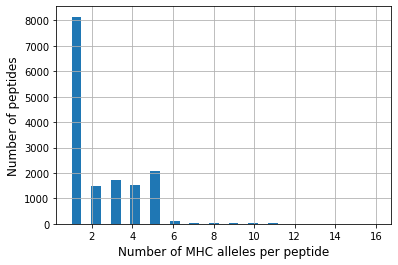

In [10]:
# considering only peptides with specified MHC allele
ax = df_tcell_consistent.loc[df_tcell_consistent['MHC Allele Name'].notna()].groupby(['Epitope Description']).size().hist(bins=31, range=(1, 16))
ax.set_xlabel("Number of MHC alleles per peptide", size=12)
_ = ax.set_ylabel("Number of peptides", size=12)

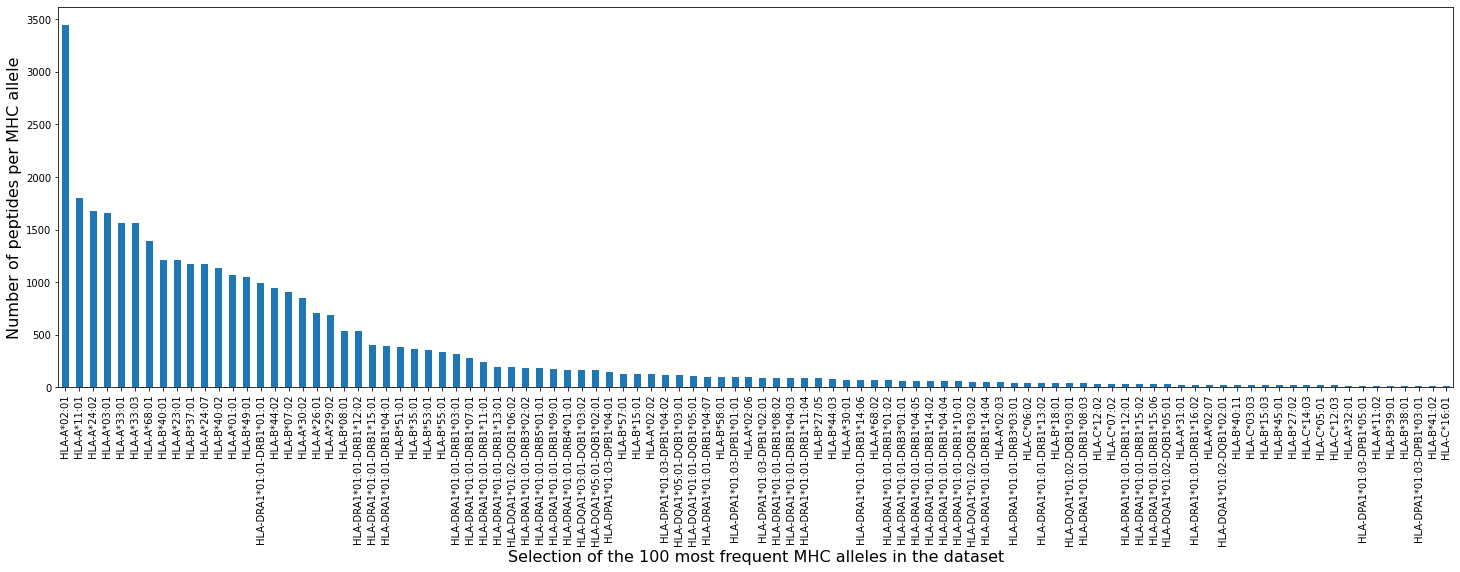

In [11]:
ax = df_tcell_consistent['MHC Allele Name'].value_counts().iloc[:100].plot.bar(figsize=(25,7))
ax.set_xlabel("Selection of the 100 most frequent MHC alleles in the dataset", size=16)
_ = ax.set_ylabel("Number of peptides per MHC allele", size=16)

In [12]:
# Total number of MHC alleles
len(df_tcell_consistent['MHC Allele Name'].unique())

225

In [13]:
# Fraction of peptide:MHC combinations covered by the 50 most frequent MHC alleles
df_tcell_consistent['MHC Allele Name'].value_counts().iloc[:50].sum()/len(df_tcell_consistent.loc[df_tcell_consistent['MHC Allele Name'].notna()])

0.9308474576271186

In [14]:
# Fraction of peptide:MHC combinations covered by the 100 most frequent MHC alleles
df_tcell_consistent['MHC Allele Name'].value_counts().iloc[:100].sum()/len(df_tcell_consistent.loc[df_tcell_consistent['MHC Allele Name'].notna()])

0.9871751412429378

<br />

### Distribution of peptide lengths

In [33]:
class_I_pep_len = df_tcell_MHC_pred_100_unique.loc[df_tcell_MHC_pred_100_unique['Epitope Parent Species'] == 'Human betaherpesvirus 6B', 'Epitope Description'].str.len().value_counts().to_frame().sort_index().reset_index()
class_II_pep_len = df_tcell_MHC_pred_100_unique.loc[df_tcell_MHC_pred_100_unique['Epitope Parent Species'] == 'Vaccinia virus', 'Epitope Description'].str.len().value_counts().to_frame().sort_index().reset_index()
class_I_pep_len.columns = ['Peptide length', 'Betaherpes']
class_II_pep_len.columns = ['Peptide length', 'Vaccinia']
pep_len_df = class_I_pep_len.merge(class_II_pep_len, how='outer', on=['Peptide length']).set_index('Peptide length').fillna(0).astype(int)

In [315]:
pep_len_df.T

Peptide length,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
MHC class I,352,8412,3963,342,59,49,38,3942,0,0,0,0,0,0,0,0,0,0
MHC class II,0,119,36,63,201,492,188,8135,260,912,5853,441,1398,91,31,27,46,161


In [854]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['axes.titlepad'] = 15
rcParams['axes.titlesize'] = 16
rcParams.update({'font.size': 15})

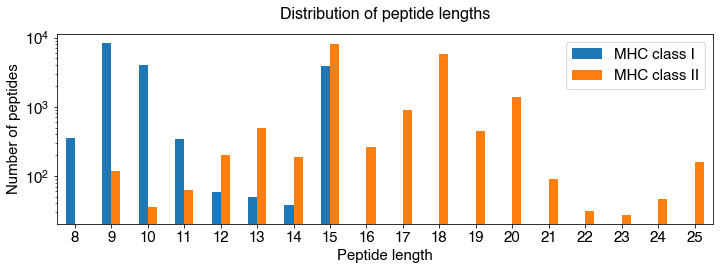

In [496]:
pep_len_df.plot.bar(figsize=(10, 4), logy=True, title='Distribution of peptide lengths', rot=0)
plt.tight_layout()
plt.ylabel("Number of peptides")
plt.savefig('../thesis/figures/pep_len_dist.pdf')

Text(60.170390624999996, 0.5, 'Number of peptides')

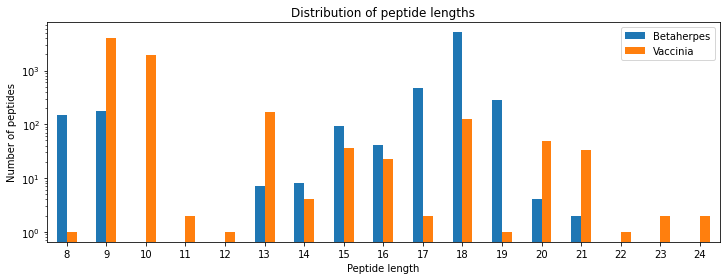

In [42]:
pep_len_df.sort_index().plot.bar(figsize=(10, 4), logy=True, title='Distribution of peptide lengths', rot=0)
plt.tight_layout()
plt.ylabel("Number of peptides")

### Peptide source distribution

In [14]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['axes.titlepad'] = 15
rcParams['axes.titlesize'] = 16
rcParams.update({'font.size': 15})

In [761]:
allele_pos_neg_count = get_values_per_column(df_tcell_MHC_pred_100_unique, 'Epitope Parent Species')
allele_pos_neg_count['Sum'] = allele_pos_neg_count['Positives'] + allele_pos_neg_count['Negatives']

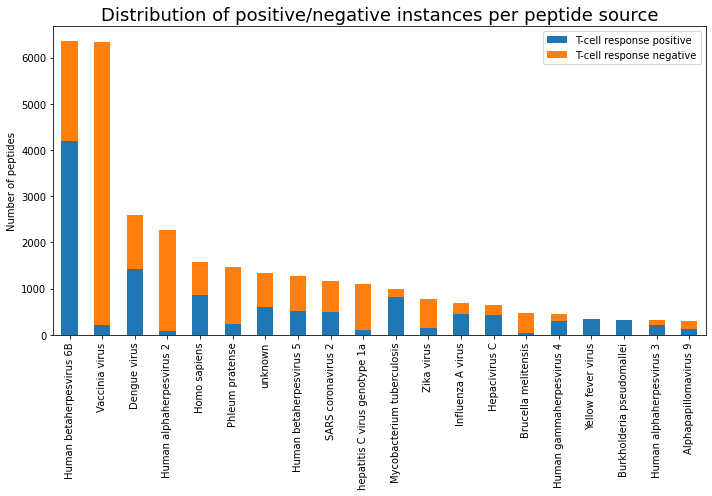

In [116]:
allele_pos_neg_count = get_values_per_column(df_tcell_MHC_pred_100_unique, 'Epitope Parent Species')
allele_pos_neg_count['Sum'] = allele_pos_neg_count['Positives'] + allele_pos_neg_count['Negatives']
# Use the SARS abbreviation
as_list = allele_pos_neg_count.index.tolist()
sars2_idx = as_list.index('Severe acute respiratory syndrome coronavirus 2')
as_list[sars2_idx] = 'SARS coronavirus 2'
allele_pos_neg_count.index = as_list
# _ = allele_pos_neg_count.iloc[:50].plot.bar(stacked=True, figsize=(13,8))
_ = allele_pos_neg_count.sort_values(['Sum'], ascending=False)[['Positives', 'Negatives']].rename(columns={"Positives": "T-cell response positive", "Negatives": "T-cell response negative"}).iloc[:20].plot.bar(stacked=True, figsize=(10,7))
plt.title('Distribution of positive/negative instances per peptide source', fontsize=18)
plt.ylabel("Number of peptides")
plt.tight_layout()
# plt.savefig('../thesis/figures/source_distribution.pdf')

### Allele distribution

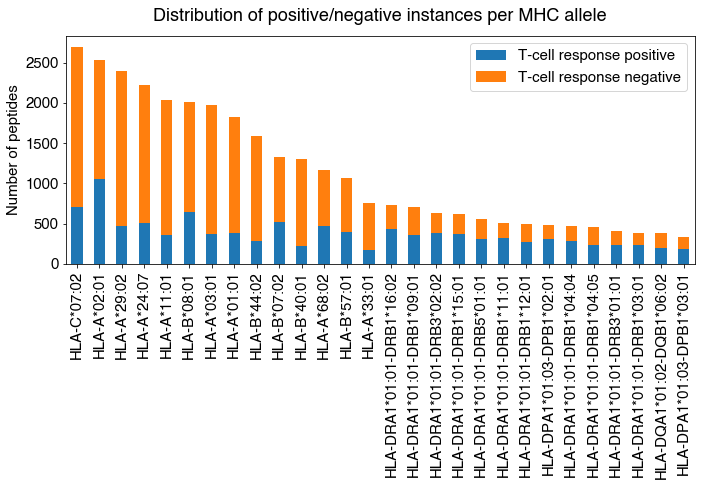

In [494]:
# single_alleles = ['HLA-C*07:02', 'HLA-A*02:01', 'HLA-A*29:02', 'HLA-A*24:07', 'HLA-A*11:01', 'HLA-B*08:01', 'HLA-B*44:02', 'HLA-B*07:02', 'HLA-A*33:01', 'default allele II', 'HLA-DRA1*01:01-DRB1*16:02', 'HLA-DRA1*01:01-DRB1*09:01', 'HLA-DRA1*01:01-DRB3*02:02', 'HLA-DRA1*01:01-DRB5*01:01', 'HLA-DRA1*01:01-DRB1*11:01', 'HLA-DRA1*01:01-DRB1*12:01', 'HLA-DPA1*01:03-DPB1*02:01', 'HLA-DRA1*01:01-DRB1*03:01', 'HLA-DQA1*01:02-DQB1*06:02']
single_alleles_I = ['HLA-C*07:02', 'HLA-A*02:01', 'HLA-A*11:01', 'HLA-B*44:02', 'HLA-B*07:02', 'HLA-A*29:02', 'HLA-A*24:07', 'HLA-B*08:01', 'HLA-A*33:01', 'HLA-A*68:02', 'HLA-B*57:01', 'HLA-B*40:01', 'HLA-A*03:01', 'HLA-A*01:01']
single_alleles_II = ['HLA-DRA1*01:01-DRB1*16:02', 'HLA-DRA1*01:01-DRB3*02:02', 'HLA-DPA1*01:03-DPB1*02:01', 'HLA-DRA1*01:01-DRB1*11:01', 'HLA-DRA1*01:01-DRB1*09:01', 'HLA-DRA1*01:01-DRB1*03:01', 'HLA-DRA1*01:01-DRB1*12:01', 'HLA-DQA1*01:02-DQB1*06:02', 'HLA-DRA1*01:01-DRB5*01:01', 'HLA-DRA1*01:01-DRB1*04:05', 'HLA-DRA1*01:01-DRB1*15:01', 'HLA-DPA1*01:03-DPB1*03:01', 'HLA-DRA1*01:01-DRB1*04:04', 'HLA-DRA1*01:01-DRB3*01:01']
single_alleles = single_alleles_I + single_alleles_II
allele_pos_neg_count = get_values_per_column(df_tcell_MHC_pred_100.loc[df_tcell_MHC_pred_100['MHC Allele Prediction'].isin(single_alleles)], 'MHC Allele Prediction')
allele_pos_neg_count['Sum'] = allele_pos_neg_count['Positives'] + allele_pos_neg_count['Negatives']
_ = allele_pos_neg_count.sort_values(['Sum'], ascending=False)[['Positives', 'Negatives']].rename(columns={"Positives": "T-cell response positive", "Negatives": "T-cell response negative"}).plot.bar(stacked=True, figsize=(10,7))
plt.title('Distribution of positive/negative instances per MHC allele', fontsize=18)
plt.ylabel("Number of peptides")
plt.tight_layout()
plt.savefig('../thesis/figures/allele_distribution.pdf')


In [70]:
peptide_clusters_sorted = sorted(peptide_clusters, key=lambda cluster: len(cluster), reverse=True)

### Peptide clusters

In [ ]:
# Table: Cluster size, Peptide source, Peptide source count, Share of peptide source

In [73]:
for peptide_cluster in peptide_clusters_sorted[:10]:
    print(len(peptide_cluster))
    display(df_tcell_unique_pep.loc[df_tcell_unique_pep['Epitope Description'].isin(peptide_cluster), 'Epitope Parent Species'].value_counts())

859


hepatitis C virus genotype 1a    704
Hepacivirus C                    155
Name: Epitope Parent Species, dtype: int64

846


Zika virus                              452
Dengue virus                            348
Yellow fever virus                       24
Dengue virus 2 D2/SG/05K4155DK1/2005     11
Japanese encephalitis virus               6
Dengue virus type 1 Hawaii                2
Dengue virus 2 S221                       2
West Nile virus                           1
Name: Epitope Parent Species, dtype: int64

560


Severe acute respiratory syndrome coronavirus 2    557
SARS-CoV1                                            3
Name: Epitope Parent Species, dtype: int64

325


hepatitis C virus genotype 1a    271
Hepacivirus C                     54
Name: Epitope Parent Species, dtype: int64

299


Human alphaherpesvirus 2    297
Human alphaherpesvirus 1      2
Name: Epitope Parent Species, dtype: int64

285


Human alphaherpesvirus 2    284
Human alphaherpesvirus 1      1
Name: Epitope Parent Species, dtype: int64

254


Human betaherpesvirus 6B    235
unknown                      18
Human betaherpesvirus 6A      1
Name: Epitope Parent Species, dtype: int64

215


Human betaherpesvirus 6B    209
unknown                       6
Name: Epitope Parent Species, dtype: int64

212


Vaccinia virus    211
Variola virus       1
Name: Epitope Parent Species, dtype: int64

211


Human alphaherpesvirus 2    180
Human alphaherpesvirus 1     31
Name: Epitope Parent Species, dtype: int64

In [80]:
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
i = 0
for peptide_cluster in peptide_clusters_sorted[:10]:
    df_peptide_cluster = df_tcell_unique_pep.loc[df_tcell_unique_pep['Epitope Description'].isin(peptide_cluster), 'Epitope Parent Species'].value_counts()
    for peptide_source, count in df_peptide_cluster.items():
        if count > 0:
            print(f'{letters[i]} [{count}] {peptide_source}')
    i += 1
    print('')
    

A [704] hepatitis C virus genotype 1a
A [155] Hepacivirus C

B [452] Zika virus
B [348] Dengue virus
B [24] Yellow fever virus
B [11] Dengue virus 2 D2/SG/05K4155DK1/2005
B [6] Japanese encephalitis virus
B [2] Dengue virus type 1 Hawaii
B [2] Dengue virus 2 S221
B [1] West Nile virus

C [557] Severe acute respiratory syndrome coronavirus 2
C [3] SARS-CoV1

D [271] hepatitis C virus genotype 1a
D [54] Hepacivirus C

E [297] Human alphaherpesvirus 2
E [2] Human alphaherpesvirus 1

F [284] Human alphaherpesvirus 2
F [1] Human alphaherpesvirus 1

G [235] Human betaherpesvirus 6B
G [18] unknown
G [1] Human betaherpesvirus 6A

H [209] Human betaherpesvirus 6B
H [6] unknown

I [211] Vaccinia virus
I [1] Variola virus

J [180] Human alphaherpesvirus 2
J [31] Human alphaherpesvirus 1



### Peptide cluster sizes

In [97]:
def peptide_cluster_statistics(peptide_clusters, df_tcell):
    # number of peptide:MHC instances per peptide cluster
    cluster_instances_count = []
    for peptide_cluster in peptide_clusters:
        instance_count = df_tcell['Epitope Description'].isin(peptide_cluster).sum()
        cluster_instances_count.append(instance_count)
        
    # number of clusters with given instance count
    instance_count_df = pd.DataFrame({'#clusters': cluster_instances_count})['#clusters'].value_counts().to_frame().sort_index()
    instance_count_df.index.name = 'number of peptides per cluster'
    instance_count_df.columns = ['number of clusters with given size']
    return instance_count_df.T

In [98]:
peptide_cluster_statistics(peptide_clusters, df_tcell_unique_pep)

number of peptides per cluster,2,3,4,5,6,7,8,9,10,11,...,211,212,215,254,285,299,325,560,846,859
number of clusters with given size,1451,422,163,126,84,60,33,39,39,21,...,1,1,1,1,1,1,1,1,1,1


<br />

### Unit tests for the k-mer graph

In [99]:
# unit tests for common_k_mer_graph()
input_peptides = ['WITQCFLPVFLA', 'WITQCFLPV', 'PQCFLPVFLAP', 'AITQCFLPV', 'AITQCFLPVA']
resulting_edges = common_k_mer_graph(input_peptides)

assert ('WITQCFLPVFLA', 'WITQCFLPV') in resulting_edges
assert ('WITQCFLPVFLA', 'PQCFLPVFLAP') in resulting_edges
assert ('AITQCFLPV', 'AITQCFLPVA') in resulting_edges
assert len(resulting_edges) == 3

In [100]:
# unit tests for generate_k_mers()
input_peptide = 'WITQCFLPVFL'
k_mer_len = 9
resulting_9mers = list(generate_k_mers(input_peptide, k=k_mer_len))

assert k_mer_len == 9
assert len(input_peptide) == 11
assert len(resulting_9mers) == 3
for peptide in resulting_9mers:
    assert len(peptide) == 9
    
input_peptide = 'WITQCFLPV'
k_mer_len = 9
resulting_9mers = list(generate_k_mers(input_peptide, k=k_mer_len))

assert k_mer_len == 9
assert len(input_peptide) == 9
assert len(resulting_9mers) == 1
for peptide in resulting_9mers:
    assert len(peptide) == 9